In [ ]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [ ]:
from planetworldmodel.setting import DATA_DIR

/home/ubuntu/planetworldmodel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Masked data generation

In [ ]:
# Generate trajectories
import argparse
import numpy as np
import tqdm

from planetworldmodel.setting import GEN_DATA_DIR
from planetworldmodel.experiments.generate_using_model import main as gen_fn

val_dataset = np.load(DATA_DIR / "two_body_problem_val.npy")
n_data = len(val_dataset)

GEN_DATA_DIR.mkdir(parents=True, exist_ok=True)

# 100 randomly selected indices
np.random.seed(0)
indices = np.random.choice(n_data, 1_000, replace=False)

for i, idx in tqdm.tqdm(enumerate(indices)):
    np.save(GEN_DATA_DIR / f"ver_full_{i+1}.npy", val_dataset[idx])
    np.save(GEN_DATA_DIR / f"ver_partial_{i+1}.npy", val_dataset[idx, : i + 1])
    # args = argparse.Namespace(
    #     config_file="config",
    #     input_sequence=f"ver_partial_{i+1}.npy",
    #     output_file=f"ver_predicted_{i+1}.npy",
    #     checkpoint=None,
    # )
    # gen_fn(args)

1000it [00:00, 8504.32it/s]


# Prediction data generation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np


def animate_trajectories(ground_truth, predicted, num_common_ts=100, num_frames=300):
    # Ensure both sequences have the same shape
    assert ground_truth.shape == predicted.shape
    total_ts, num_coords = ground_truth.shape
    assert num_coords == 4, "Input should have 4 coordinates (x1, y1, x2, y2)"
    assert num_common_ts <= total_ts, "num_common_ts cannot exceed total timesteps"

    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot full ground truth trajectories
    ax.plot(
        ground_truth[:, 0],
        ground_truth[:, 1],
        np.zeros(total_ts),
        "y--",
        alpha=0.3,
        linewidth=0.5,
        label="GT Trajectory 1",
    )
    ax.plot(
        ground_truth[:, 2],
        ground_truth[:, 3],
        np.zeros(total_ts),
        "b--",
        alpha=0.3,
        linewidth=0.5,
        label="GT Trajectory 2",
    )

    # Plot predicted trajectories (only the part after initial common timesteps)
    (pred_line_1,) = ax.plot(
        predicted[num_common_ts:, 0],
        predicted[num_common_ts:, 1],
        np.zeros(total_ts - num_common_ts),
        "r--",
        alpha=0.3,
        linewidth=0.5,
    )
    (pred_line_2,) = ax.plot(
        predicted[num_common_ts:, 2],
        predicted[num_common_ts:, 3],
        np.zeros(total_ts - num_common_ts),
        "m--",
        alpha=0.3,
        linewidth=0.5,
    )

    # Initialize object positions
    (gt_pos_1,) = ax.plot([], [], [], "yo", markersize=10, label="GT Object 1")
    (gt_pos_2,) = ax.plot([], [], [], "bo", markersize=10, label="GT Object 2")
    (pred_pos_1,) = ax.plot(
        [], [], [], "r^", markersize=10, visible=False
    )  # Initially invisible
    (pred_pos_2,) = ax.plot(
        [], [], [], "m^", markersize=10, visible=False
    )  # Initially invisible

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Ground Truth vs Predicted Trajectories (Common TS: {num_common_ts})")

    # Create a legend without the predicted trajectories initially
    ax.legend()

    prediction_started = False

    # Animation update function
    def update(frame):
        nonlocal prediction_started

        # Update ground truth positions
        gt_pos_1.set_data([ground_truth[frame, 0]], [ground_truth[frame, 1]])
        gt_pos_1.set_3d_properties([0])
        gt_pos_2.set_data([ground_truth[frame, 2]], [ground_truth[frame, 3]])
        gt_pos_2.set_3d_properties([0])

        # Update predicted positions
        if frame < num_common_ts:
            pred_pos_1.set_visible(False)
            pred_pos_2.set_visible(False)
        else:
            pred_pos_1.set_visible(True)
            pred_pos_2.set_visible(True)
            pred_pos_1.set_data([predicted[frame, 0]], [predicted[frame, 1]])
            pred_pos_1.set_3d_properties([0])
            pred_pos_2.set_data([predicted[frame, 2]], [predicted[frame, 3]])
            pred_pos_2.set_3d_properties([0])

            # Add predicted trajectories to legend if not already added
            if not prediction_started:
                pred_pos_1.set_label("Pred Object 1")
                pred_pos_2.set_label("Pred Object 2")
                pred_line_1.set_label("Pred Trajectory 1")
                pred_line_2.set_label("Pred Trajectory 2")
                ax.legend()
                prediction_started = True

        return gt_pos_1, gt_pos_2, pred_pos_1, pred_pos_2

    frames = np.linspace(0, total_ts - 1, num_frames, dtype=int)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

    # Set up the writer
    writer = FFMpegWriter(fps=30, metadata=dict(artist="Me"), bitrate=1800)

    # Save the animation
    anim.save(f"predicted_traj_{num_common_ts}.mp4", writer=writer)


# Usage:
# ground_truth = np.load(GEN_DATA_DIR / "ver_full_100.npy")
# predicted = np.load(GEN_DATA_DIR / "ver_predicted_100.npy")
# animate_trajectories(ground_truth, predicted, num_common_ts=100)

In [ ]:
import numpy as np
from planetworldmodel.setting import GEN_DATA_DIR


for i in range(100, 1000, 100):
    args = argparse.Namespace(
        config_file="config",
        input_sequence=f"ver_partial_{i}.npy",
        output_file=f"ver_predicted_{i}.npy",
        checkpoint=None,
    )
    gen_fn(args)

    ground_truth = np.load(GEN_DATA_DIR / f"ver_full_{i}.npy")
    predicted = np.load(GEN_DATA_DIR / f"ver_predicted_{i}.npy")
    animate_trajectories(ground_truth, predicted, i)

# Ablation

In [ ]:
# Generate trajectories
import argparse
import numpy as np
import tqdm

from planetworldmodel.setting import DATA_DIR, GEN_DATA_DIR
from planetworldmodel.experiments.generate_using_model import main as gen_fn

ground_truth = np.load(GEN_DATA_DIR / "ver_full_800.npy")
for i in tqdm.trange(20, 800, 20):
    partial = ground_truth[800 - i : 800, :]
    np.save(GEN_DATA_DIR / f"ablation_partial_{i}.npy", partial)
    args = argparse.Namespace(
        config_file="config",
        input_sequence=f"ablation_partial_{i}.npy",
        output_file=f"ablation_predicted_{i}.npy",
        checkpoint=None,
    )
    gen_fn(args)

  0%|          | 0/39 [00:00<?, ?it/s]INFO:planetworldmodel.experiments.generate_using_model:Configuration loaded.
INFO:planetworldmodel.experiments.generate_using_model:Using device: cuda
INFO:planetworldmodel.experiments.generate_using_model:Input sequence loaded with shape (20, 4).
/home/ubuntu/planetworldmodel/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:planetworldmodel.experiments.generate_using_model:Loading checkpoint from /home/ubuntu/planetworldmodel/planetworldmodel/checkpoints/trial1/last.ckpt
/home/ubuntu/planetworldmodel/planetworldmodel/experiments/generate_using_model.py:45: FutureWarning: You are using `torch.load` with `weights_only=

INFO:planetworldmodel.experiments.generate_using_model:Model loaded and ready for generation.
INFO:planetworldmodel.experiments.generate_using_model:Initial sequence length: 20
INFO:planetworldmodel.experiments.generate_using_model:Generated 100 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 200 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 300 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 400 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 500 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 600 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 700 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 800 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 900 / 1000 steps
INFO:planetworldmodel.experiments.generate_using_model:Generated 1000 / 1000 steps
IN

In [ ]:
# Generate trajectories
import argparse
import numpy as np
import tqdm

from planetworldmodel.setting import DATA_DIR, GEN_DATA_DIR
from planetworldmodel.experiments.generate_using_model import main as gen_fn

ground_truth = np.load(GEN_DATA_DIR / "ver_full_800.npy")
ground_truth_partial = ground_truth[-200:, :]
mses = {}
for i in tqdm.trange(20, 800, 20):
    prediction = np.load(GEN_DATA_DIR / f"ablation_predicted_{i}.npy")
    prediction_partial = prediction[i : i + 200, :]
    mse = np.mean((ground_truth_partial - prediction_partial) ** 2)
    mses[i] = mse

100%|██████████| 39/39 [00:00<00:00, 7729.43it/s]


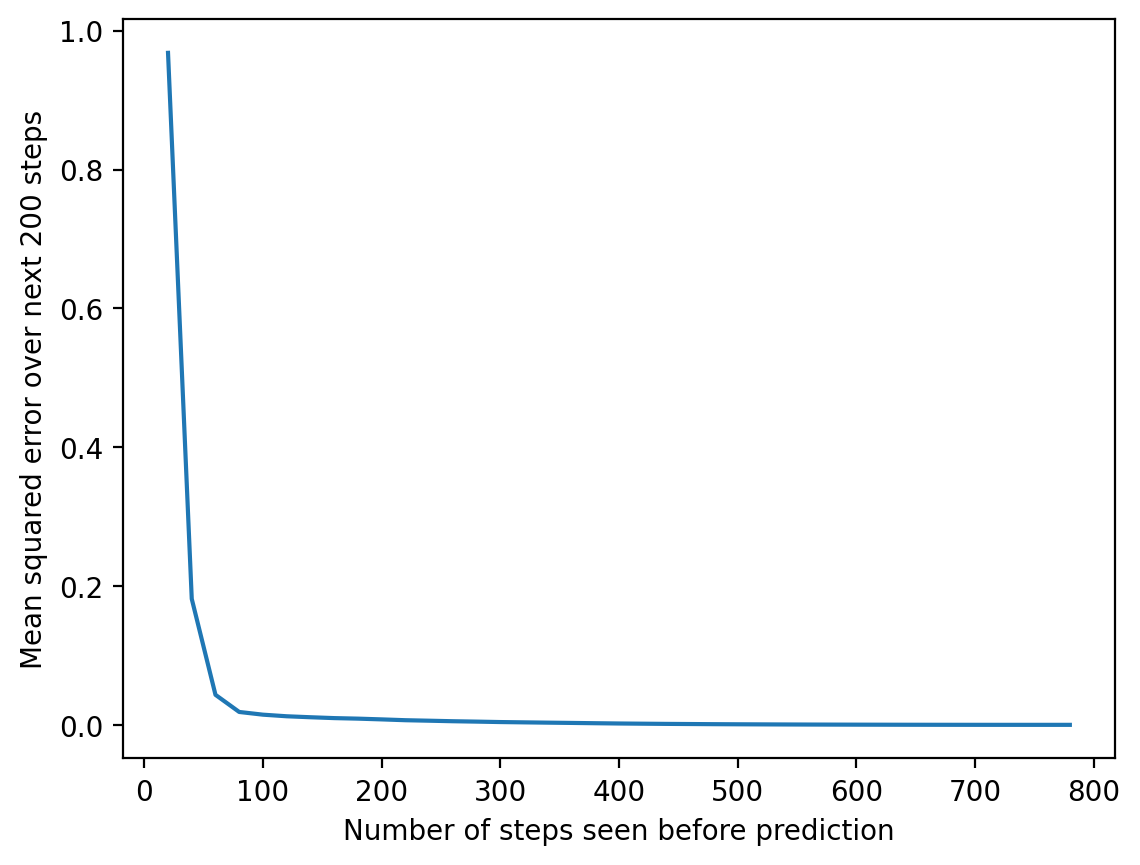

In [ ]:
# Plot

plt.plot(list(mses.keys()), list(mses.values()))
plt.xlabel("Number of steps seen before prediction")
plt.ylabel("Mean squared error over next 200 steps")
plt.show()

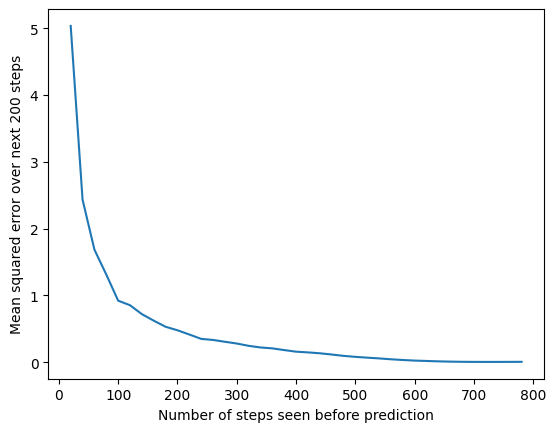

In [ ]:
# Plot
import matplotlib.pyplot as plt

plt.plot(list(mses.keys()), list(mses.values()))
plt.xlabel("Number of steps seen before prediction")
plt.ylabel("Mean squared error over next 200 steps")
plt.show()

In [ ]:
args = argparse.Namespace(
    config_file="config",
    input_sequence="ver_partial_500.npy",
    output_file="ver_predicted_500.npy",
    checkpoint=None,
)
gen_fn(args)

INFO:planetworldmodel.experiments.generate_using_model:Configuration loaded.
INFO:planetworldmodel.experiments.generate_using_model:Using device: cuda
INFO:planetworldmodel.experiments.generate_using_model:Input sequence loaded with shape (500, 4).
/home/ubuntu/planetworldmodel/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:planetworldmodel.experiments.generate_using_model:Loading checkpoint from /home/ubuntu/planetworldmodel/planetworldmodel/checkpoints/regressor/last.ckpt
/home/ubuntu/planetworldmodel/planetworldmodel/experiments/generate_using_model.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value)

In [ ]:
import numpy as np

val_dataset = np.load(DATA_DIR / "two_body_problem_val.npy")
n_data = len(val_dataset)

gen_data_dir = DATA_DIR / "gen_data"
gen_data_dir.mkdir(parents=True, exist_ok=True)

# 100 randomly selected indices
np.random.seed(0)
indices = np.random.choice(n_data, 100, replace=False)

for i, idx in enumerate(indices):
    np.save(gen_data_dir / f"ver_full_{i+1}.npy", val_dataset[idx])
    np.save(gen_data_dir / f"ver_partial_{i+1}.npy", val_dataset[idx, : i + 1])